In [1]:
import tdt
import os
import pywt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns

from Struct_class import *
from scipy import signal, integrate

from pywt import dwt

from sklearn.mixture import GaussianMixture

In [2]:
rats = os.listdir('{}/Raw Data/'.format(os.getcwd()))

i=0
rat = rats[i]

blocks = os.listdir('{}/Raw Data/{}'.format(os.getcwd(), rat))
print(rat, blocks)

20220419_rat4 ['1-bl', '2', '3', '4', '5', '6', '7', '8', 'test1']


In [3]:
block = blocks[1]
data = Struct(tdt.read_block('Raw Data/{}/{}'.format(rat, block)))
data.preprocess()

fs = data.streams.SU_3.fs

read from t=0s to t=1147.24s


In [4]:
def samples_to_ms(num, fs):
    """
    Converts each data point to a time in miliseconds.
    
    Inputs
    ------
    num : int, float or arrary
        Contains the data being converted to a time
        
    fs : float
        The sampling frequency
    
    Outputs
    -------
    return : numpy array
        Contains the time data
    """
    
    if type(num) is int:
        return num * (1000 / fs)
    elif type(num) is np.ndarray or type(num) is list:
        return np.array([(n * 1000 / fs) for n in num])
    else:
        print('Invalid Inputs, Returning Original Input.')
        return num
    
def ms_to_samples(ms, fs):
    """
    Converts each time in miliseconds to data points
    
    Inputs
    ------
    ms : int, float or arrary
        Contains the time being converted to data
        
    fs : float
        The sampling frequency
    
    Outputs
    -------
    return : numpy array
        Contains the data points
    """
    
    if type(ms) is int:
        return ms * (1 / 1000) * fs
    elif type(ms) is np.ndarray or type(ms) is list:
        return np.array([m * (1 / 1000) * fs for m in ms])
    else:
        print('Invalid inputs, Returning Original Input.')
        return ms

In [5]:
def filter_signal(data, filter_type = 'bp', low_freq = 300, high_freq = 6000, filter_order = 5):
    """
    Filter the signal according to some specifications. 
    
    Inputs
    ------
    data : Struct class (from Struct_class.py)
        Contains a block of preprocessed data from TDT
        
    filter_type : string
        The type of Butterworth filter to use.
        Must be 'hp' for highpass, or 'bp' for bandpass
        It will default to 'bp'
    
    low_freq : float
        high-pass frequency of the bandpass or highpass filter.
        
    high_freq : float
        Low-pass frequency of the bandpass filter
        
    filter_order : int
        Order of the Butterworth filter to use
    
    Outputs
    -------
    filtered_trace : numpy array
        Filtered trace of signal
    """
    
    # Extract useful parameters
    trace = data.streams.SU_3.data
    fs = data.streams.SU_3.fs
    
    # Filter the data
    if filter_type == 'hp':
        b, a = signal.butter(filter_order, low_freq, btype=filter_type, fs=fs)
    else:
        b, a = signal.butter(filter_order, [low_freq, high_freq], btype=filter_type, fs=fs)
    
    filtered_trace = signal.lfilter(b, a, trace)
    
    return filtered_trace

In [6]:
def spike_thresholding(filtered_trace, nstdevs=4, direction ='both', median_noise_filter=True):
    """
    This function will return snippets of the data that have spikes greater than a threshold determined by 
    a number of standard deviations. 
    
    Inputs
    ------
    filtered_trace : numpy array
        Trace of signal after it was been filtered (output of the filter_signal function)
        
    nstdevs : float or int
        Number of standard deviations to use for the threshold of the data
        Defaults to 4
        
     direction : string
         The direction of the signal taken
         Defaults to both
         
    median_noide_filter : bool
        Determines which method will be used to find the threshold
        Defualts to true
     
    Outputs
    -------
    spike_inds : numpy array
        Contains the indices of the spikes which pass the threshold
    """
    
    # Using the Equation from R. Quian Quiroga
    # NB: sigma = median(abs(filtered_trace)/0.6745)
    if median_noise_filter:
        threshold = nstdevs * np.median(abs(filtered_trace)/0.6745)
    
    else: #Standard deviation threshold
        threshold = nstdevs * np.std(filtered_trace)
    
    # Direction of threshold
    if direction =='positive' or direction == 'Positive':
        spike_inds = np.where(filtered_trace >= threshold)[0]

    elif direction == 'negative' or direction == 'Negative':
        spike_inds = np.where(filtered_trace <= -threshold)[0]

    else: # Both
        spike_inds = np.where(np.abs(filtered_trace) >= threshold)[0]
            
    # Find successive points and add zero to array
    non_successive = np.insert(np.where(np.diff(spike_inds) > 1)[0] + 1, 0, 0)

    # Get a list of successive points found by thresholding and create a zipped array that has the start/stop of successive
    # points above or below the threshold
    zipped = np.asarray(list(zip([spike_inds[non_successive[:-1]], spike_inds[non_successive[1:]-1]]))).squeeze().T

    # Only keep max indices
    spike_inds = np.array([a + np.argmax(np.abs(filtered_trace[a:b+1])) for a, b in zipped])
    
    return spike_inds

In [7]:
# Function to give windows
def get_spike_traces(filtered_trace, spike_inds, wstart=20, wend=44):
    """
    This function will return the values of the spikes who indices cross the threshold.
    
    Inputs
    ------
    filtered_trace : numpy array
        Trace of signal after it was been filtered (output of the filter_signal function)
    
    spike_inds : numpy array
        Contains the indexes of the spikes which pass the threshold (output of the spike_thresholding function)
        
    wstart : int
        Where the spike is centered
        Defaults to 20
    
    wend : int
        Where the window ends relative to the center
        Defaults to 44
        
    Outputs
    -------
    spike_traces : numpy array
        Contains the values of the spikes which passed the threshold
    """
    
    spike_traces = np.empty((len(spike_inds), wstart + wend))
    
    for i in range(len(spike_inds)):
        start = spike_inds[i] - wstart
        stop = spike_inds[i] + wend
        try:
            spike_traces[i] = filtered_trace[start:stop]
        except:
            pass
    
    return spike_traces

In [8]:
filtered_signal = filter_signal(data, low_freq=300, high_freq=6000, filter_order=5)
spike_inds = spike_thresholding(filtered_signal, nstdevs=4, direction='positive')
spike_traces = get_spike_traces(filtered_signal, spike_inds)

In [9]:
print(len(spike_inds))

990


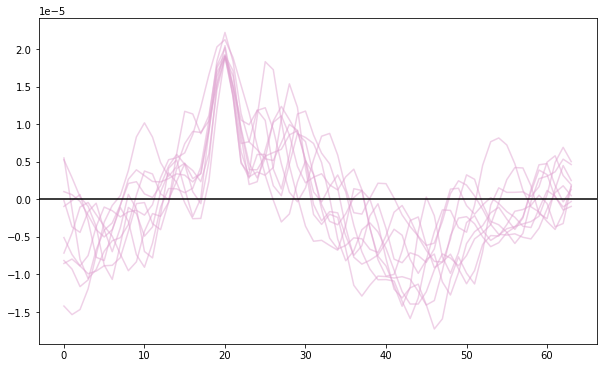

In [10]:
# Plots the trace
%matplotlib inline
fig,ax = plt.subplots(figsize=(10, 6))

for trace in spike_traces[::100]:
    ax.plot(trace, alpha=0.5, color='#E0A4D1')
    #ax.scatter(filtered_trace[spike_inds[i]], color='k', s=25)

plt.axhline(y = 0, color = 'k', linestyle = '-'); #Creates a visual for when the trace crosses zero

### Zero Crossing Features

In [11]:
def zcr_features(spike_traces, wstart=20):
    """
    This fuction performs zero crossing feature extraction on the trace
    See Computationally Efficient Neural Feature Extraction for Spike Sorting in Implantable High-Density Recording Systems
    
    Inputs
    ------
    spike_traces : numpy array
        Contains the values of the spikes which passed the threshold (output of the get_spike_traces function)

    wstart : int
        Where the spike is centered
        Defaults to 20

    Outputs
    -------
    ZC1s : numpy array
        Sum of values before the first zero crossing of the spike after wstart
        
    ZC2s : numpy array 
        Sum of values after the first zero crossing of the spike after wstart
    """
    
    # NB fix this if using negative and positive
    ZC1s = np.empty(len(spike_traces))
    ZC2s = np.empty_like(ZC1s)

    for i in range(len(spike_traces)):
        trace = spike_traces[i]
        try:
            Z_index = np.where(trace[wstart:] <= 0)[0][0] + wstart
        except:
            Z_index = len(trace)
        ZC1s[i] = np.sum(trace[:Z_index])
        ZC2s[i] = np.sum(trace[Z_index:])
        
    return ZC1s, ZC2s

In [12]:
ZC1s, ZC2s = zcr_features(spike_traces)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
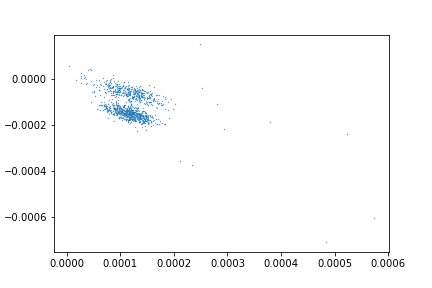

In [13]:
# Plots the zero crossing feature extraction
%matplotlib widget
fig, ax = plt.subplots()

ax.scatter(ZC1s, ZC2s, s=.1);

### Amplitude

In [14]:
def amplitude(spike_traces):
    """
    This fuction performs amplitude feature extraction on the trace
    
    Inputs
    ------
    spike_traces : numpy array
        Contains the values of the spikes which passed the threshold (output of the get_spike_traces function)

    Outputs
    -------
    max_amp : numpy array
        The maximum amplitudes of the traces
        
    min_amp : numpy array 
        The minimum amplitudes of the traces
        
    amp_range : numpy array
        The diffence between the maximum and minimum amplitudes of the trace
    """

    # Positive Peak Amplitude
    max_amp = np.empty(len(spike_traces))
    for i in range(len(spike_traces)):
        max_amp[i] = np.max(spike_traces[i])

    # Negative Peak Amplitude
    min_amp = np.empty(len(spike_traces))
    for i in range(len(spike_traces)):
        min_amp[i] = np.min(spike_traces[i])

    # Amplitude Range (Peak-to-Valley Amplitude)
    amp_range = abs(max_amp) + abs(min_amp)
    
    return max_amp, min_amp, amp_range

### Width

In [15]:
def width(spike_traces):
    """
    This fuction performs width feature extraction on the trace
    
    Inputs
    ------
    spike_traces : numpy array
        Contains the values of the spikes which passed the threshold (output of the get_spike_traces function)
    
    Outputs
    -------
    pv_width : numpy array
        The width in units of time from the peak to the valley of the traces
    """

    # Peak-to-Valley Width
    pos_index = np.empty(len(spike_traces))
    neg_index = np.empty_like(pos_index)

    for i in range(len(spike_traces)):
        pos_index[i] = np.argmax(spike_traces[i])
        neg_index[i] = np.argmin(spike_traces[i, 20:]) + 20

    pv_width = samples_to_ms(neg_index - pos_index, fs) # Converted to ms, therefore it's a waveform duration
    
    return pv_width

### Gradient (Deflection, Slope)

In [16]:
def gradient(spike_traces, max_amp, min_amp, pv_width, distance=10):
    """
    This fuction performs gradient (slope) feature extraction on the trace
    
    Inputs
    ------
    spike_traces : numpy array
        Contains the values of the spikes which passed the threshold (output of the get_spike_traces function)
        
    max_amp : numpy array
        The maximum amplitudes of the traces (output of the amplitude function)
        
    min_amp : numpy array 
        The minimum amplitudes of the traces (output of the amplitude function)
    
    pv_width : numpy array
        The width in units of time from the peak to the valley of the traces (output from width function)
        
    distance : int
        The number of indices taken on either side of the peak amplitude

    Outputs
    -------
    slope_left : numpy array
        The slope of the left side of the peak of the traces
        
    slope_right : numpy array
        The slope of the right side of the peak of the traces
        
    slope : numpy array
        The slope from the peak to the valley of the traces
    """

    # Left Gradient
    left = np.empty(len(spike_traces))
    for i in range(len(spike_traces)):
        left[i] = spike_traces[i][np.argmax(spike_traces[i]) - distance]
    slope_left = (max_amp - left) / distance

    # Right Gradient
    right = np.empty(len(spike_traces))
    for i in range(len(spike_traces)):
        right[i] = spike_traces[i][np.argmax(spike_traces[i]) - distance]
    slope_right = (max_amp - right) / distance

    # Peak-to-Peak Gradient
    slope = (min_amp - max_amp) / pv_width
    
    return slope_left, slope_right, slope

### Integration

In [17]:
def integration(spike_traces):
    """
    This fuction performs integration feature extraction on the trace
    
    Inputs
    ------
    spike_traces : numpy array
        Contains the values of the spikes which passed the threshold (output of the get_spike_traces function)

    Outputs
    -------
    integration_trap : numpy array
        The results of trapezoidal integration on the traces
    """

    # Integration Over the Entire Signal Using the Trapezoidal Method
    integration = np.empty(len(spike_traces))
    for i in range(len(spike_traces)):
        integration_trap[i] = integrate.trapz(spike_traces[i])

    return integration_trap

### Discrete Wavelet Analysis

In [18]:
def wave(spike_traces, wavelet='db1', mode='sym'):
    """
    This fuction performs discrete wavelet analysis on the trace
    
    Inputs
    ------
    spike_traces : numpy array
        Contains the values of the spikes which passed the threshold (output of the get_spike_traces function)
        
    wavelet : string
        The type of discrete wavelet transform used
        Defaults to db1
        
    mode : string
        The signal extension mode to deal with the border distortion problem
    
    
    Outputs
    -------
    cA : numpy array
        The approximation coefficients of the wavelet transform
        The length depends on the selected signal entension mode
        
    cD : numpy array
        The detail coeffictients of the wavelet transform
        The length depends on the selected signal entension mode
    """
    
    (cA, cD) = dwt(spike_traces, wavelet, mode)
    
    return cA, cD

In [19]:
(cA, cD) = wave(spike_traces)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
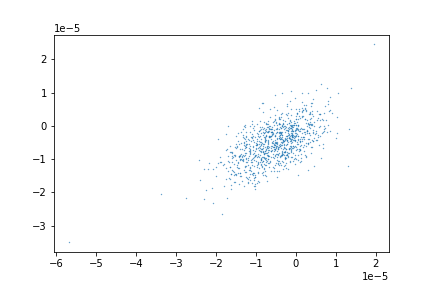

In [20]:
# Plots the discrete wavelet analysis
%matplotlib widget
fig, ax = plt.subplots()

ax.scatter(cA[:,0], cA[:,1], s=.1);

### Gaussian Mixture Model Clustering

In [21]:
c = np.array([cA[:,0], cA[:,1]]).T

gmm = GaussianMixture(n_components=3).fit(c)
labels = gmm.predict(c)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
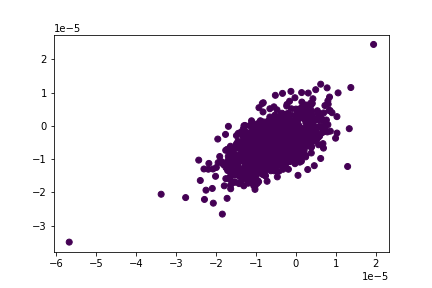

In [22]:
# Plots the Clusters
%matplotlib widget
fig, ax = plt.subplots()

plt.scatter(c[:, 0], c[:, 1], c=labels, cmap='viridis');